In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import inferpy as inf
import tensorflow_probability as tfp
import xgboost as xg
from sklearn.model_selection import train_test_split

In [2]:
def display_draws(x_data, y_data, draw_inputs, draw_outputs, label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(x_data, y_data, 'ks', alpha=0.5, label='(x, y)')
    ax.plot(draw_inputs, draw_outputs[0].T, 'r', lw=2, alpha=0.5, label=label)
    ax.plot(draw_inputs, draw_outputs[1:].T, 'r', lw=2, alpha=0.5)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 3])
    ax.legend()
    plt.show()

In [3]:
@inf.probmodel
def linear_reg(d):
    w0 = inf.Normal(0, 1, name="w0")
    w = inf.Normal(np.zeros([d, 1]), 1, name="w")

    with inf.datamodel():
        x = inf.Normal(tf.ones(d), 2, name="x")
        y = inf.Normal(w0 + x @ w, 1.0, name="y")

In [4]:
@inf.probmodel
def qmodel(d):
    qw0_loc = inf.Parameter(0., name="qw0_loc")
    qw0_scale = tf.math.softplus(inf.Parameter(1., name="qw0_scale"))
    qw0 = inf.Normal(qw0_loc, qw0_scale, name="w0")

    qw_loc = inf.Parameter(np.zeros([d, 1]), name="qw_loc")
    qw_scale = tf.math.softplus(inf.Parameter(tf.ones([d, 1]), name="qw_scale"))
    qw = inf.Normal(qw_loc, qw_scale, name="w")

In [5]:
# create an instance of the model
m = linear_reg(d=2)
q = qmodel(2)

In [6]:
# create toy train data
N = 1000
data = m.prior(["x", "y"], data={"w0": 0, "w": [[2], [1]]}, size_datamodel=N).sample()
x_data = data["x"]
y_data = data["y"]

In [7]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(x_data, y_data, test_size = 0.1, random_state = 123) 

In [8]:
X_test_xgb.shape

(100, 2)

In [9]:
y_train_xgb.shape

(900, 1)

In [10]:
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123) 

In [11]:
# Fitting the model 
xgb_r.fit(X_train_xgb, y_train_xgb) 

[16:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10, seed=123)

In [12]:
# Predict the model 
pred = xgb_r.predict(X_test_xgb)
print(pred)

[ 1.4065202e+00  3.5064588e+00  5.8943808e-01  3.5965446e-01
  5.5135150e+00  4.3279266e+00 -3.0451274e-01  4.7647233e+00
  2.1654348e+00  2.1654348e+00  4.1501756e+00  5.5135150e+00
  1.2062826e+00 -3.0451274e-01  5.8943808e-01 -3.1498661e+00
  7.5545897e+00  3.9059103e+00  4.6804218e+00 -7.8206718e-01
  7.5545897e+00  4.9557815e+00  3.0991285e+00  2.1654348e+00
  2.1506815e+00  2.4759383e+00  5.5135150e+00  2.9612875e+00
  1.9356511e+00  4.1501756e+00 -9.8559666e-01  2.8941302e+00
  4.9557815e+00  6.9829564e+00  5.6785059e+00  2.3764546e+00
  4.9557815e+00 -8.6505747e-01  2.1654348e+00  6.5625014e+00
 -2.9331660e+00 -2.0859761e+00  5.5135150e+00  2.1654348e+00
  5.8943808e-01  3.0991285e+00  3.1531193e+00  4.5453906e-03
 -8.0841887e-01  4.5453906e-03  3.5965446e-01  6.7402530e+00
  3.9448171e+00 -1.0258942e+00  4.1501756e+00  4.4744268e-01
  4.1501756e+00  3.7118173e+00  5.0193677e+00  5.5338478e+00
  2.1654348e+00  2.1654348e+00  2.9612875e+00  4.5432740e-01
  1.0501177e+00  3.15311

In [13]:
# Predict the model 
pred_train_xgb = xgb_r.predict(x_data)
#print(pred_train_xgb)

In [14]:
@inf.probmodel
def xgboost_reg(d, xgb_r):
#     w0 = inf.Normal(0, 1, name="w0")
#     w = inf.Normal(np.ones([d, 1]), 0.1, name="w")
    N = 100
    with inf.datamodel():
        x = inf.Normal(tf.ones(d), 2, name="x")
        with tf.Session() as sess:
            sample = sess.run(x.sample(N))
#             w0_sample = sess.run(w0.sample(N))
#             w_sample = sess.run(w.sample(N))
        print(sample.shape)
        sample_mean = xgb_r.predict(sample).mean()
        sample_stdev = xgb_r.predict(sample).std()
        sample_mean_dist = inf.Normal(tf.constant(sample_mean, shape=tf.ones(1).shape), 1.0, name="sample_mean_dist")
#         w0_mean = w0_sample.mean()
#         w_mean = w_sample.mean()
        print(sample_mean)
        y = inf.Normal(sample_mean_dist , 5*sample_stdev , name="y")

In [15]:
@inf.probmodel
def xgboost_qmodel(d):

#     qw0_loc = inf.Parameter(0., name="qw0_loc")
#     qw0_scale = tf.math.softplus(inf.Parameter(1., name="qw0_scale"))
#     w0 = inf.Normal(qw0_loc, 1.0, name="w0")
    
#     qw_loc = inf.Parameter(np.zeros([d, 1]), name="qw_loc")
#     qw_scale = tf.math.softplus(inf.Parameter(tf.ones([d, 1]), name="qw_scale"))
#     qw = inf.Normal(qw_loc, qw_scale, name="w")

    sample_mean_dist_loc = inf.Parameter(np.ones(1), name="sample_mean_dist_loc")
    #sample_mean_dist_scale = tf.math.softplus(inf.Parameter(2*tf.ones(1), name="sample_mean_dist_scale"))
    sample_mean_dist_scale = inf.Parameter(tf.ones(1), name="sample_mean_dist_scale")
    sample_mean_dist = inf.Normal(sample_mean_dist_loc, sample_mean_dist_scale, name="sample_mean_dist")

In [16]:
# create an instance of the model
m1 = xgboost_reg(2, xgb_r)
q1 = xgboost_qmodel(2)

(100, 2)
2.1321557
(100, 2)
2.0535161


In [17]:
# set and run the inference
VI = inf.inference.VI(q1, epochs=1000)
m1.fit({"x": x_data, "y": y_data}, VI)

(100, 2)
1.7398012

 0 epochs	 9244.10546875....................
 200 epochs	 8881.154296875....................
 400 epochs	 9686.2744140625....................
 600 epochs	 9035.57421875....................
 800 epochs	 8690.8115234375....................

In [18]:
# extract the parameters of the posterior
m1.posterior(["sample_mean_dist"]).parameters()

{'name': 'sample_mean_dist',
 'allow_nan_stats': True,
 'validate_args': False,
 'scale': array([0.5300853], dtype=float32),
 'loc': array([1.4689794], dtype=float32)}

30


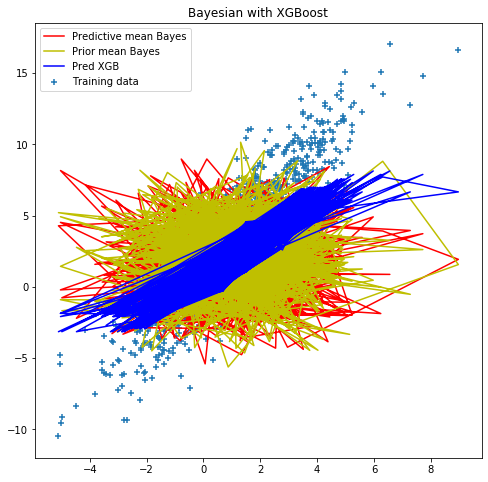

In [25]:
#x_test = np.linspace(-20.5, 20.5, NSAMPLE).reshape(-1, 1)

plt.figure(figsize=(8, 8))

y_pred_list = []
y_prior_list = []
for i in range(30):
    y_test = m1.posterior_predictive(["y"], data = {"x": x_data}).sample()
    y_prior = m1.prior(["y"]).sample(1000)
    y_pred_list.append(y_test.reshape(1000,1))
    y_prior_list.append(y_prior.reshape(1000,1))
    
print(len(y_pred_list))
y_preds = np.concatenate(y_pred_list, axis=1)
y_prior = np.concatenate(y_prior_list, axis=1)

y_p10 = np.percentile(y_preds, 10, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)
y_prior_mean = np.mean(y_prior, axis=1)

plt.plot(x_data[:,0], y_mean, 'r-', label='Predictive mean Bayes');
plt.plot(x_data[:,0], y_prior_mean, 'y-', label='Prior mean Bayes');
#plt.plot(x_data[:,0], y_p10, 'g-', label='p10');
plt.plot(x_data[:,0], pred_train_xgb, 'b-', label='Pred XGB');
plt.scatter(x_data[:,0], y_data, marker='+', label='Training data')
# plt.fill_between(x_data[:,0].ravel(),
#                  y_mean + 2 * y_sigma,
#                  y_mean - 2 * y_sigma,
#                  alpha=0.5, label='Epistemic uncertainty')
#plt.xticks(np.arange(-20., 20.5, 4))
plt.title('Bayesian with XGBoost')
plt.legend();